# Проект «Мегалайн»

## Цели

Исследование двух тарифных планов с целью выявления наиболее прибыльного.

## Задачи

- Исследовать поведения абонентов двух тарифов (количество звонков и сообщений, время разговоров и расход интернет-трафика)
- Сравнение основных показателей тарифов на основании имеющейся выборки (средней выручки и выручки по регионам)

## Описание данных

Данные представлены в пяти таблицах.

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер звонка
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Загрузка необходимых библиотек и данных

In [1]:
import sys
from distutils.version import StrictVersion

if StrictVersion(sys.version.split()[0]) < StrictVersion('3.8.0'):
    !pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 976 kB/s eta 0:00:01


In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st

In [3]:
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", 100)

In [4]:
sns.set_style("whitegrid")

In [5]:
plt.rcParams["figure.figsize"] = (12, 8)

In [6]:
try:
    df_calls = pd.read_csv("calls.csv")
except FileNotFoundError:
    df_calls = pd.read_csv("/datasets/calls.csv")

In [7]:
try:
    df_internet = pd.read_csv("internet.csv", index_col="Unnamed: 0")
except FileNotFoundError:
    df_internet = pd.read_csv("/datasets/internet.csv")

In [8]:
try:
    df_messages = pd.read_csv("messages.csv")
except FileNotFoundError:
    df_messages = pd.read_csv("/datasets/messages.csv")

In [9]:
try:
    df_tariffs = pd.read_csv("tariffs.csv")
except FileNotFoundError:
    df_tariffs = pd.read_csv("/datasets/tariffs.csv")

In [10]:
try:
    df_users = pd.read_csv("users.csv")
except FileNotFoundError:
    df_users = pd.read_csv("/datasets/users.csv")

## Подготовка данных

Первым делом изучем полученные данные на предмет пропусков и аномальных значений. 

### Таблица тарифов

In [11]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [12]:
df_tariffs.dtypes

messages_included         int64
mb_per_month_included     int64
minutes_included          int64
rub_monthly_fee           int64
rub_per_gb                int64
rub_per_message           int64
rub_per_minute            int64
tariff_name              object
dtype: object

Таблица с описаниями тарифов, значения и их типы в порядке. Можно было бы преобразовать колонку `tariff_name` к категориальному типу, но вданном случае, когда каждое значение представлено единожды, это кажется чтрезмерным.

### Таблица пользователей

In [13]:
df_users[~df_users["churn_date"].isna()].head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart


In [14]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Колонки `reg_date` и `churn_date` имеют строковый тип, хотя хранят дату регистрации у мобильного оператора и дату ухода от него. Кроме того, дата ухода имеет пропуски, что, очевидно, указывает на то, что клиент на 2018 год остаётся с оператором. Приведём колонки к типу `datetime`

In [15]:
DATE_FORMAT = "%Y-%m-%d"

In [16]:
df_users["reg_date"] = pd.to_datetime(df_users["reg_date"], format=DATE_FORMAT)
df_users["churn_date"] = pd.to_datetime(df_users["churn_date"], format=DATE_FORMAT)

Тариф клиента является категориальной переменной с двумя возможными значениями

In [17]:
df_users["tariff"] = df_users["tariff"].astype("category")

In [18]:
df_users.describe(include="all")

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
count,500.00,500.00,38,500,500,500,500,500
unique,NaN,NaN,33,76,246,419,270,2
top,NaN,NaN,2018-10-03 00:00:00,Москва,Радим,Андреенко,2018-05-28 00:00:00,smart
freq,NaN,NaN,2,99,6,5,8,351
first,NaN,NaN,2018-08-17 00:00:00,NaN,NaN,NaN,2018-01-01 00:00:00,NaN
last,NaN,NaN,2018-12-30 00:00:00,NaN,NaN,NaN,2018-12-31 00:00:00,NaN
mean,1249.50,46.59,NaN,NaN,NaN,NaN,NaN,NaN
std,144.48,16.67,NaN,NaN,NaN,NaN,NaN,NaN
min,1000.00,18.00,NaN,NaN,NaN,NaN,NaN,NaN
25%,1124.75,32.00,NaN,NaN,NaN,NaN,NaN,NaN


Аномальных значений не заметно: все даты в заданном диапазоне (в пределах 2018 года), возраста - от 18 до 75 лет.

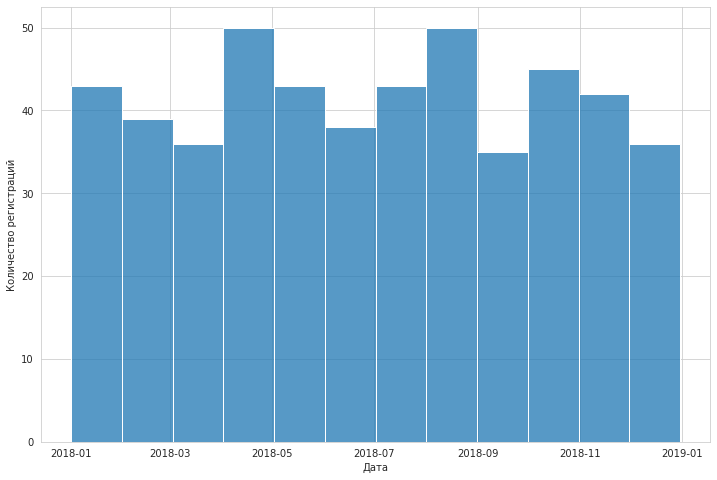

In [22]:
ax=sns.histplot(data=df_users, x="reg_date", bins=12)
ax.set_xlabel("Дата")
ax.set_ylabel("Количество регистраций");

In [23]:
df_users.groupby(pd.Grouper(key="reg_date", freq="1M"))["user_id"].count().median()

41.5

Клиенты регистрировались у оператора более-менее равномерно в течение  года с медианной скоростью чуть более 40 человек в месяц.

''

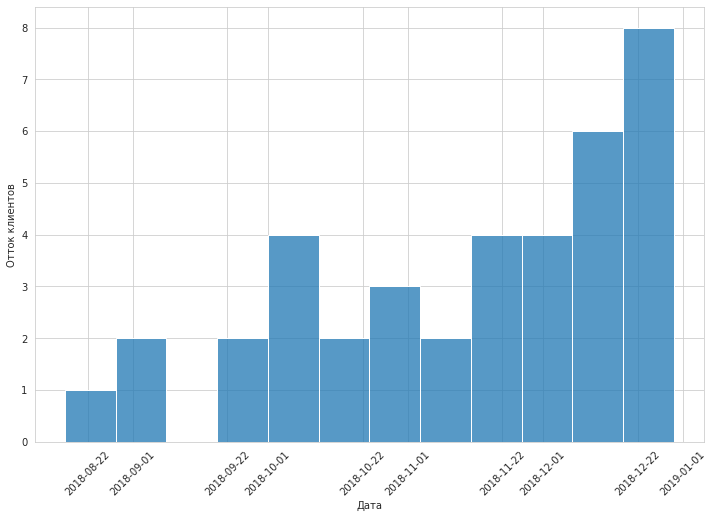

In [30]:
ax = sns.histplot(data=df_users, x="churn_date", bins=12)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Дата")
ax.set_ylabel("Отток клиентов");

Объём месячного оттока растёт приблизительно линейно, что согласуется с почти линейным ростом клиентской базы.

### Таблица звонков

In [31]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [32]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Колонка `call_date` имеет строковый тип, хотя хранит дату звонка. Приведём её к типу `datetime`

In [33]:
df_calls["call_date"] = pd.to_datetime(df_calls["call_date"], format=DATE_FORMAT)

Поскольку нас интересуют округлённые вверх значение длительностей звонков, сразу преобразуем вещественные значения в целые:

In [37]:
df_calls["duration"] = np.ceil(df_calls["duration"]).astype("int")

In [46]:
df_calls.describe(include='all')

,id,call_date,duration,user_id
count,202607,202607,202607.00,202607.00
unique,202607,365,NaN,NaN
top,1179_389,2018-12-31 00:00:00,NaN,NaN
freq,1,1435,NaN,NaN
first,NaN,2018-01-01 00:00:00,NaN,NaN
last,NaN,2018-12-31 00:00:00,NaN,NaN
mean,NaN,NaN,7.16,1253.94
std,NaN,NaN,5.96,144.72
min,NaN,NaN,0.00,1000.00
25%,NaN,NaN,2.00,1126.00


Аномальных значений не видно: продолжительность разговоров от 0 дло 38 минут, даты звонков в диапазоне 1 января - 31 декабря 2018, `user_id` - [1000, 1499] 

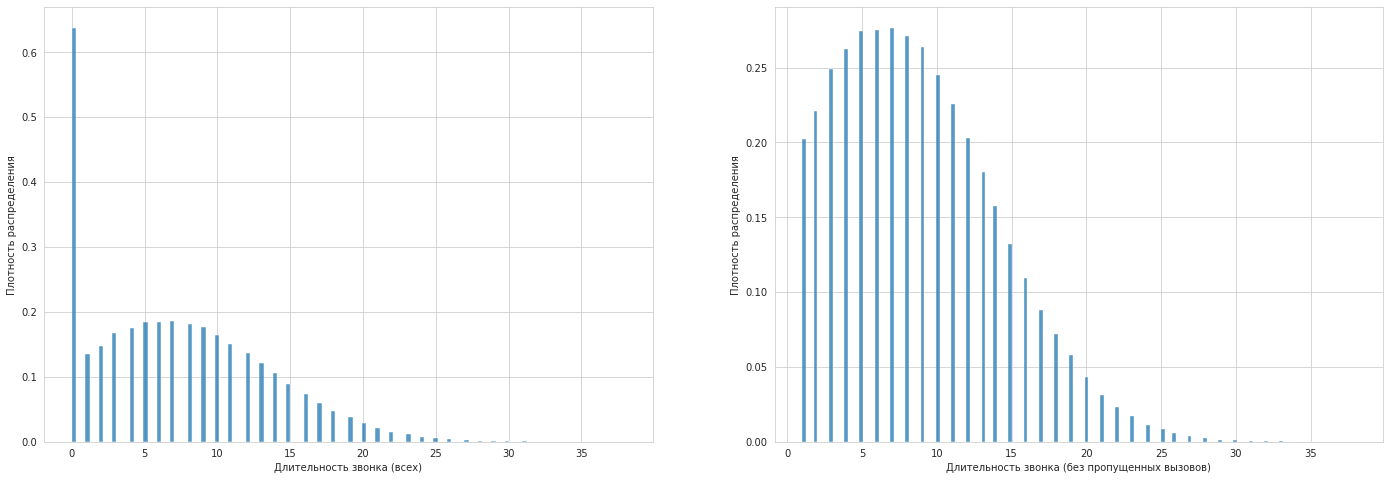

In [39]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

sns.histplot(ax=ax1, data=df_calls, x="duration", stat="density")
ax1.set_xlabel("Длительность звонка (всех)")
ax1.set_ylabel("Плотность распределения")

sns.histplot(
    ax=ax2, data=df_calls[df_calls["duration"] > 0], x="duration", stat="density"
)
ax2.set_xlabel("Длительность звонка (без пропущенных вызовов)")
ax2.set_ylabel("Плотность распределения");

### Таблица интернет-сессий

In [40]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [41]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Колонка `session_date` имеет строковый тип, хотя хранит дату начала интернет-сессии. Приведём её к типу `datetime`

In [42]:
df_internet["session_date"] = pd.to_datetime(
    df_internet["session_date"], format=DATE_FORMAT
)

In [45]:
df_internet.describe(include='all')

,Unnamed: 0,id,mb_used,session_date,user_id
count,149396.00,149396,149396.00,149396,149396.00
unique,NaN,149396,NaN,365,NaN
top,NaN,1324_354,NaN,2018-12-31 00:00:00,NaN
freq,NaN,1,NaN,1057,NaN
first,NaN,NaN,NaN,2018-01-01 00:00:00,NaN
last,NaN,NaN,NaN,2018-12-31 00:00:00,NaN
mean,74697.50,NaN,370.19,NaN,1252.10
std,43127.05,NaN,278.30,NaN,144.05
min,0.00,NaN,0.00,NaN,1000.00
25%,37348.75,NaN,138.19,NaN,1130.00


Точно также преобразуем `session_date` в `datetime`:

In [47]:
df_internet["session_date"] = pd.to_datetime(
    df_internet["session_date"], format=DATE_FORMAT
)

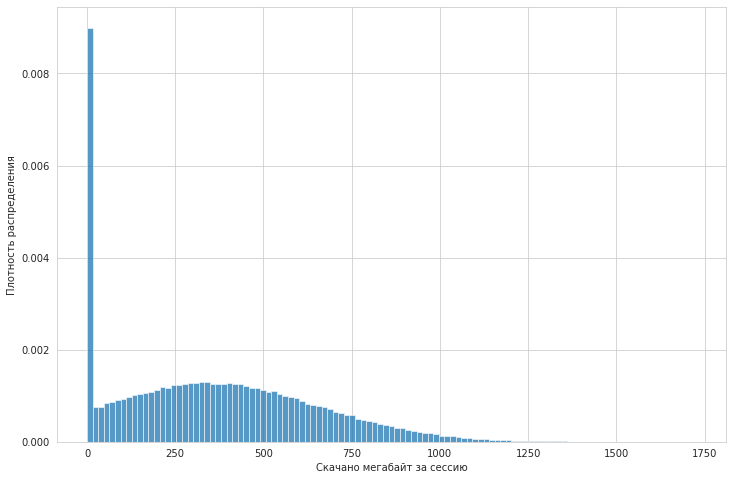

In [48]:
ax = sns.histplot(data=df_internet, x="mb_used", stat="density")
ax.set_xlabel("Скачано мегабайт за сессию")
ax.set_ylabel("Плотность распределения");

Диаграмма плотности интернет-сессий очень похожа на аналогичный график звонков и показывает, что среди интернет-сессий имеется аномально много нулевых. Возможно, это указывает на проблемы с доступом к сети, когда сессия обрывается сразу после открытия.

In [49]:
df = df_internet.merge(right=df_users, on="user_id", how="left")
df["churned"] = np.where(~pd.isnull(df["churn_date"]), True, False)
df1 = df[df["mb_used"] == 0].groupby(["churned", "user_id"])["user_id"].count()
df1[True].describe(), df1[False].describe()

(count     34.00
 mean      26.09
 std       25.62
 min        1.00
 25%       10.00
 50%       13.50
 75%       40.25
 max      107.00
 Name: user_id, dtype: float64,
 count    460.00
 mean      40.68
 std       31.52
 min        1.00
 25%       14.00
 50%       32.50
 75%       64.00
 max      144.00
 Name: user_id, dtype: float64)

Не похоже, что эти пустые сессии стали причиной недовольства пользователей: медианное количество у тех, кто ушёл вдвое меньше, чем у тех, кто остался. Видимо, ничего страшного в пустых интернет-сессиях нет (с точки зрения пользователей мобильной связи, но не аналитика). Так что от них нужно избавиться

In [50]:
df_internet.drop(df_internet.loc[df_internet["mb_used"] == 0].index, inplace=True)

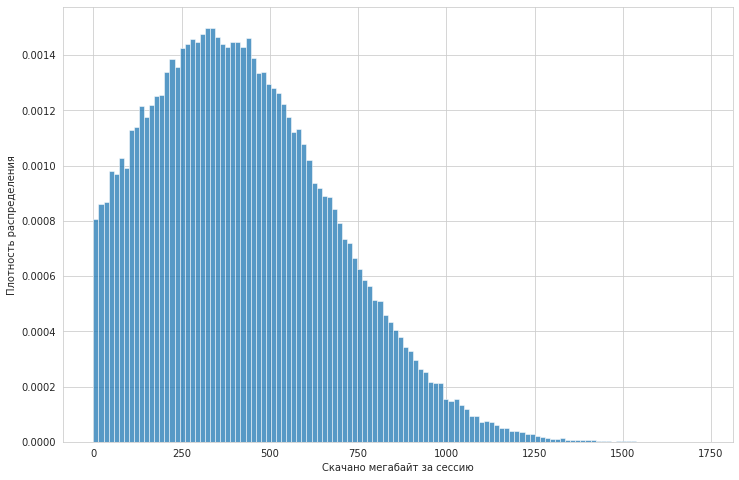

In [51]:
ax = sns.histplot(data=df_internet, x="mb_used", stat="density")
ax.set_xlabel("Скачано мегабайт за сессию")
ax.set_ylabel("Плотность распределения");

### Таблица сообщений

In [52]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [53]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Точно также преобразуем `message_date` в `datetime`:

In [54]:
df_messages["message_date"] = pd.to_datetime(
    df_messages["message_date"], format=DATE_FORMAT
)

In [56]:
df_messages.describe(include='all')

,id,message_date,user_id
count,123036,123036,123036.00
unique,123036,364,NaN
top,1448_32,2018-12-31 00:00:00,NaN
freq,1,859,NaN
first,NaN,2018-01-02 00:00:00,NaN
last,NaN,2018-12-31 00:00:00,NaN
mean,NaN,NaN,1256.99
std,NaN,NaN,143.52
min,NaN,NaN,1000.00
25%,NaN,NaN,1134.00


Точно также преобразуем `message_date` в `datetime`:

In [57]:
df_messages["message_date"] = pd.to_datetime(
    df_messages["message_date"], format=DATE_FORMAT
)

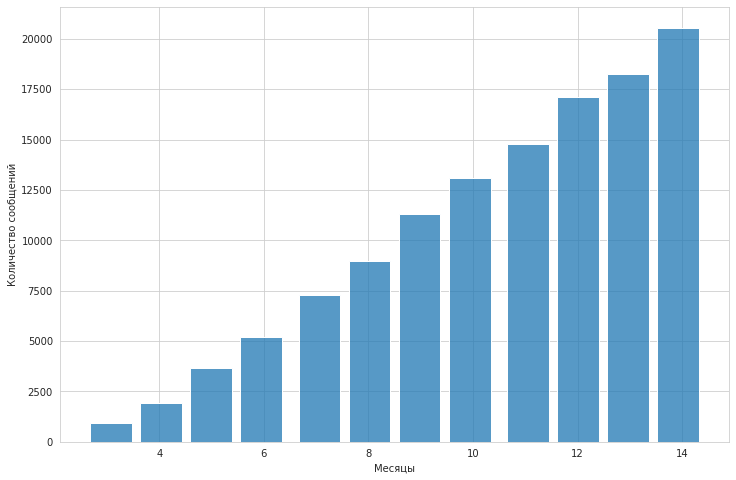

In [58]:
ax = sns.histplot(
    x=df_messages["message_date"].dt.month + 2,
    shrink=5,
)
ax.set_xlabel("Месяцы")
ax.set_ylabel("Количество сообщений");

Количество сообщений растёт линейно вместе с клиентской базой

Наконец, проверим данные на наличие дубликатов

In [59]:
(
    df_users.duplicated().sum(),
    df_calls.duplicated().sum(),
    df_messages.duplicated().sum(),
    df_internet.duplicated().sum(),
    df_tariffs.duplicated().sum(),
)

(0, 0, 0, 0, 0)

Как видно, дубликатов нет.

### Выводы

Данные во всех датасетах не содержат пропусков. Единственное исключение &mdash; параметр `churn_date` в файле `users`, но это и логично: большинство участников исследования не покинули оператора связи. 

В таблице интернет-сессий было выявлено большое количество пустых сессий (в ходе которых не было передачи данных). Эти сессии удалены.

## Вычисление вспомогательных параметров

Для дальнейшего анализа нам потребуются вычислить дополнительные параметры по каждому из клиентов, как то: 
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (с учётом бесплатных лимитов по тарифам).

In [60]:
month_rus = [
    "Январь",
    "Февраль",
    "Март",
    "Апрель",
    "Май",
    "Июнь",
    "Июль",
    "Август",
    "Сентябрь",
    "Октябрь",
    "Ноябрь",
    "Декабрь",
]

Добавим в датасет пользователей данные о звонках (количество и общая продолжительность) по месяцам:

In [61]:
df_calls["call_month"] = df_calls["call_date"].dt.month

pt = df_calls.pivot_table(
    index="user_id",
    values="duration",
    columns="call_month",
    aggfunc=["count", "sum"],
).reset_index()

pt.columns = (
    ["user_id"]
    + [f"calls_{x}" for x in range(1, 12 + 1)]
    + [f"calls_duration_{x}" for x in range(1, 12 + 1)]
)
df_users = df_users.merge(pt, on="user_id", how="left")
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_1,calls_2,calls_3,calls_4,calls_5,calls_6,calls_7,calls_8,calls_9,calls_10,calls_11,calls_12,calls_duration_1,calls_duration_2,calls_duration_3,calls_duration_4,calls_duration_5,calls_duration_6,calls_duration_7,calls_duration_8,calls_duration_9,calls_duration_10,calls_duration_11,calls_duration_12
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,NaN,NaN,NaN,NaN,22.0,43.0,47.0,52.0,58.0,57.0,43.0,46.0,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,NaN,NaN,NaN,NaN,NaN,15.0,26.0,42.0,36.0,33.0,32.0,33.0,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,134.0,108.0,115.0,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,NaN,NaN,NaN,NaN,9.0,31.0,22.0,19.0,26.0,29.0,19.0,21.0,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0


Видно, что в данных много пропусков, это связано с тем, что в эти месяцы клиент ещё не пользовался услучами оператора.

Теперь добавим количество сообщений по месяцам для каждого пользователя:

In [62]:
df_messages["message_month"] = df_messages["message_date"].dt.month

pt = df_messages.pivot_table(
    index="user_id",
    values="id",
    columns="message_month",
    aggfunc="count",
).reset_index()

pt.columns = ["user_id"] + [f"messages_{x}" for x in range(1, 12 + 1)]

df_users = df_users.merge(pt, on="user_id", how="left")
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_1,calls_2,calls_3,calls_4,calls_5,calls_6,calls_7,calls_8,calls_9,calls_10,calls_11,calls_12,calls_duration_1,calls_duration_2,calls_duration_3,calls_duration_4,calls_duration_5,calls_duration_6,calls_duration_7,calls_duration_8,calls_duration_9,calls_duration_10,calls_duration_11,calls_duration_12,messages_1,messages_2,messages_3,messages_4,messages_5,messages_6,messages_7,messages_8,messages_9,messages_10,messages_11,messages_12
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,NaN,NaN,NaN,NaN,22.0,43.0,47.0,52.0,58.0,57.0,43.0,46.0,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,NaN,NaN,NaN,NaN,NaN,15.0,26.0,42.0,36.0,33.0,32.0,33.0,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,134.0,108.0,115.0,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,NaN,NaN,NaN,NaN,9.0,31.0,22.0,19.0,26.0,29.0,19.0,21.0,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0


Наконец, добавим информацию об использовании интернета: количество сессий и общий трафик за месяц, округлённый вверх до гигабайта:

In [63]:
df_internet["internet_month"] = df_internet["session_date"].dt.month

In [64]:
pt = df_internet.pivot_table(
    index="user_id",
    values="mb_used",
    columns="internet_month",
    aggfunc=["count", "sum"],
).reset_index()

pt.columns = (
    ["user_id"]
    + [f"sessions_{x}" for x in range(1, 12 + 1)]
    + [f"mb_used_{x}" for x in range(1, 12 + 1)]
)

# округлим интернет-трафик вверх до гигабайта
for m in range(1, 12 + 1):
    pt[f"mb_used_{m}"] = np.ceil(pt[f"mb_used_{m}"] / 1024) * 1024
df_users = df_users.merge(pt, on="user_id", how="left")
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_1,calls_2,calls_3,calls_4,calls_5,calls_6,calls_7,calls_8,calls_9,calls_10,calls_11,calls_12,calls_duration_1,calls_duration_2,calls_duration_3,calls_duration_4,calls_duration_5,calls_duration_6,calls_duration_7,calls_duration_8,calls_duration_9,calls_duration_10,calls_duration_11,calls_duration_12,messages_1,messages_2,messages_3,messages_4,messages_5,messages_6,messages_7,messages_8,messages_9,messages_10,messages_11,messages_12,sessions_1,sessions_2,sessions_3,sessions_4,sessions_5,sessions_6,sessions_7,sessions_8,sessions_9,sessions_10,sessions_11,sessions_12,mb_used_1,mb_used_2,mb_used_3,mb_used_4,mb_used_5,mb_used_6,mb_used_7,mb_used_8,mb_used_9,mb_used_10,mb_used_11,mb_used_12
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,NaN,NaN,NaN,NaN,22.0,43.0,47.0,52.0,58.0,57.0,43.0,46.0,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,NaN,NaN,NaN,NaN,4.0,44.0,28.0,27.0,25.0,27.0,23.0,19.0,NaN,NaN,NaN,NaN,3072.0,23552.0,14336.0,14336.0,15360.0,15360.0,15360.0,10240.0
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18432.0,14336.0
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,NaN,NaN,NaN,NaN,NaN,15.0,26.0,42.0,36.0,33.0,32.0,33.0,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0,NaN,NaN,NaN,NaN,NaN,27.0,44.0,50.0,44.0,36.0,44.0,52.0,NaN,NaN,NaN,NaN,NaN,11264.0,18432.0,20480.0,17408.0,14336.0,19456.0,18432.0
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,134.0,108.0,115.0,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,22.0,25.0,20.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9216.0,13312.0,15360.0,12288.0,10240.0
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,NaN,NaN,NaN,NaN,9.0,31.0,22.0,19.0,26.0,29.0,19.0,21.0,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0,NaN,NaN,NaN,NaN,24.0,33.0,32.0,50.0,32.0,37.0,33.0,37.0,NaN,NaN,NaN,NaN,14336.0,18432.0,22528.0,28672.0,15360.0,19456.0,16384.0,18432.0


Ещё для анализа нам потребуется информация о тратах пользователей с учётом бесплатных лимитов по тарифам. Для этого напишем пару функций:

In [65]:
def month_payment(month, row):
    """
    функция принимает номер месяца [1,12] и строку датафрейма с данными, возвращает платёж за месяц
    """
    tariff = row["tariff"]
    payment = int(
        df_tariffs.loc[df_tariffs["tariff_name"] == tariff, "rub_monthly_fee"]
    )

    minutes_included = int(
        df_tariffs.loc[df_tariffs["tariff_name"] == tariff, "minutes_included"]
    )
    if (not np.isnan(row[f"calls_duration_{month}"])) and (
        row[f"calls_duration_{month}"] > minutes_included
    ):
        rub_per_minute = int(
            df_tariffs.loc[df_tariffs["tariff_name"] == tariff, "rub_per_minute"]
        )
        payment += (row[f"calls_duration_{month}"] - minutes_included) * rub_per_minute

    messages_included = int(
        df_tariffs.loc[df_tariffs["tariff_name"] == tariff, "messages_included"]
    )
    if (not np.isnan(row[f"messages_{month}"])) and (
        row[f"messages_{month}"] > messages_included
    ):
        rub_per_message = int(
            df_tariffs.loc[df_tariffs["tariff_name"] == tariff, "rub_per_message"]
        )
        payment += (row[f"messages_{month}"] - messages_included) * rub_per_message

    mb_per_month_included = int(
        df_tariffs.loc[df_tariffs["tariff_name"] == tariff, "mb_per_month_included"]
    )
    if (not np.isnan(row[f"mb_used_{month}"])) and (
        row[f"mb_used_{month}"] > mb_per_month_included
    ):
        rub_per_gb = int(
            df_tariffs.loc[df_tariffs["tariff_name"] == tariff, "rub_per_gb"]
        )
        payment += (row[f"mb_used_{month}"] - mb_per_month_included) / 1024 * rub_per_gb
    return payment


def payments(row):
    """
    функция принимает строку датафрейма с данными row, вычисляет платёжи за каждый месяц и заносит их в row.
    Возвраящает пересчитанную строку row
    """
    for m in range(1, 12 + 1):
        if m < row["reg_date"].month:
            payment = np.nan
        else:
            payment = month_payment(m, row)
        row[f"payment_{m}"] = payment
    return row

In [66]:
df_users = df_users.apply(payments, axis=1);

In [67]:
df_users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_1,calls_2,calls_3,calls_4,calls_5,calls_6,calls_7,calls_8,calls_9,calls_10,calls_11,calls_12,calls_duration_1,calls_duration_2,calls_duration_3,calls_duration_4,calls_duration_5,calls_duration_6,calls_duration_7,calls_duration_8,calls_duration_9,calls_duration_10,calls_duration_11,calls_duration_12,messages_1,messages_2,messages_3,messages_4,messages_5,messages_6,messages_7,messages_8,messages_9,messages_10,messages_11,messages_12,sessions_1,sessions_2,sessions_3,sessions_4,sessions_5,sessions_6,sessions_7,sessions_8,sessions_9,sessions_10,sessions_11,sessions_12,mb_used_1,mb_used_2,mb_used_3,mb_used_4,mb_used_5,mb_used_6,mb_used_7,mb_used_8,mb_used_9,mb_used_10,mb_used_11,mb_used_12,payment_1,payment_2,payment_3,payment_4,payment_5,payment_6,payment_7,payment_8,payment_9,payment_10,payment_11,payment_12
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,NaN,NaN,NaN,NaN,22.0,43.0,47.0,52.0,58.0,57.0,43.0,46.0,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,NaN,NaN,NaN,NaN,4.0,44.0,28.0,27.0,25.0,27.0,23.0,19.0,NaN,NaN,NaN,NaN,3072.0,23552.0,14336.0,14336.0,15360.0,15360.0,15360.0,10240.0,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18432.0,14336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1150.0,550.0
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,NaN,NaN,NaN,NaN,NaN,15.0,26.0,42.0,36.0,33.0,32.0,33.0,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0,NaN,NaN,NaN,NaN,NaN,27.0,44.0,50.0,44.0,36.0,44.0,52.0,NaN,NaN,NaN,NaN,NaN,11264.0,18432.0,20480.0,17408.0,14336.0,19456.0,18432.0,NaN,NaN,NaN,NaN,NaN,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,134.0,108.0,115.0,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,22.0,25.0,20.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9216.0,13312.0,15360.0,12288.0,10240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,NaN,NaN,NaN,NaN,9.0,31.0,22.0,19.0,26.0,29.0,19.0,21.0,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0,NaN,NaN,NaN,NaN,24.0,33.0,32.0,50.0,32.0,37.0,33.0,37.0,NaN,NaN,NaN,NaN,14336.0,18432.0,22528.0,28672.0,15360.0,19456.0,16384.0,18432.0,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,15.0,69.0,77.0,101.0,73.0,80.0,77.0,71.0,66.0,100.0,75.0,84.0,95.0,456.0,606.0,712.0,595.0,612.0,569.0,619.0,479.0,723.0,547.0,592.0,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0,6.0,22.0,25.0,24.0,20.0,24.0,19.0,19.0,21.0,19.0,28.0,24.0,3072.0,8192.0,11264.0,10240.0,8192.0,10240.0,8192.0,8192.0,7168.0,8192.0,13312.0,9216.0,550.0,550.0,886.0,1186.0,835.0,886.0,775.0,949.0,556.0,1219.0,694.0,838.0
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart,NaN,3.0,46.0,47.0,56.0,53.0,49.0,42.0,54.0,44.0,62.0,50.0,NaN,42.0,286.0,356.0,370.0,478.0,316.0,275.0,360.0,267.0,372.0,379.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,43.0,33.0,38.0,34.0,50.0,45.0,39.0,48.0,28.0,45.0,NaN,2048.0,17408.0,14336.0,13312.0,13312.0,20480.0,19456.0,16384.0,20480.0,13312.0,19456.0,NaN,550.0,950.0,550.0,550.0,550.0,1550.0,1350.0,750.0,1550.0,550.0,1350.0
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart,NaN,NaN,NaN,25.0,67.0,68.0,69.0,74.0,87.0,69.0,81.0

### Выводы

Данные подготовлены к анализу: в датафрейм `df_users`  были добавлены помесячные данные об использованных услугах и уплаченных по тарифу суммах для каждого клиента.

## Анализ данных

Теперь изучим получившиеся данные в разрезе двух имеющихся тарифом. Для начала вычислим показатели использования звонков по тарифам:

In [68]:
calls = pd.wide_to_long(df_users, ["calls_"], i="user_id", j="month")[
    ["tariff", "calls_"]
].rename(columns={"calls_": "calls"})

calls.groupby("tariff").agg(["median", "mean", "std", "var"])

calls                      
       median   mean   std      var
tariff                             
smart    60.0  58.62  25.8   665.44
ultra    75.0  76.02  42.4  1798.04

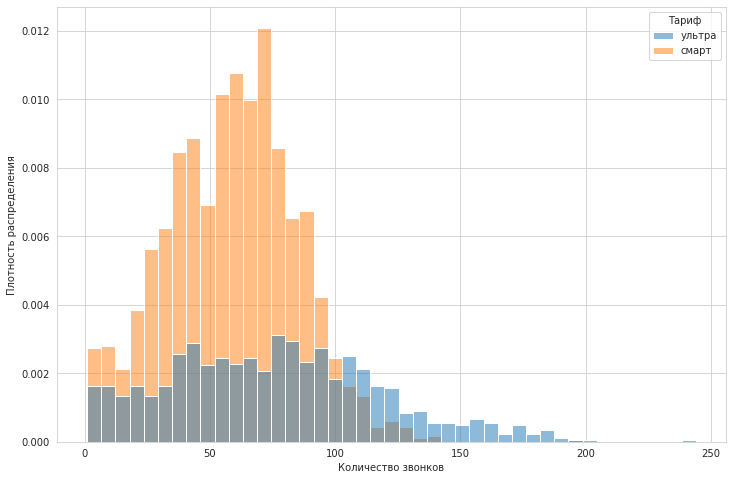

In [69]:
ax = sns.histplot(data=calls, x="calls", hue="tariff", stat="density")
ax.set_xlabel("Количество звонков")
ax.legend(ax.get_legend().legendHandles, ["ультра", "смарт"], title="Тариф")
ax.set_ylabel("Плотность распределения");

Видно, что распределение количества звонков в тарифе "Смарт" более компактно и расположено в диапазоне 0-150 с ярко выраженным пиком в между 60 и 80 звонками. При это м в тарифе "Ультра" имеются в заметных колтчествах как пользователи, делающие небольшое количество звонков, так и звонящие очень часто. Вплоть до 250 вызовов в месяц.

И по продолжительности звонков:

In [70]:
durations = pd.wide_to_long(df_users, ["calls_duration_"], i="user_id", j="month")[
    ["tariff", "calls_duration_"]
].rename(columns={"calls_duration_": "calls_duration"})
durations.groupby("tariff").agg(["median", "mean", "std", "var"])

calls_duration                          
               median    mean     std       var
tariff                                         
smart           423.0  419.06  189.33  35844.19
ultra           528.0  545.45  306.93  94203.42

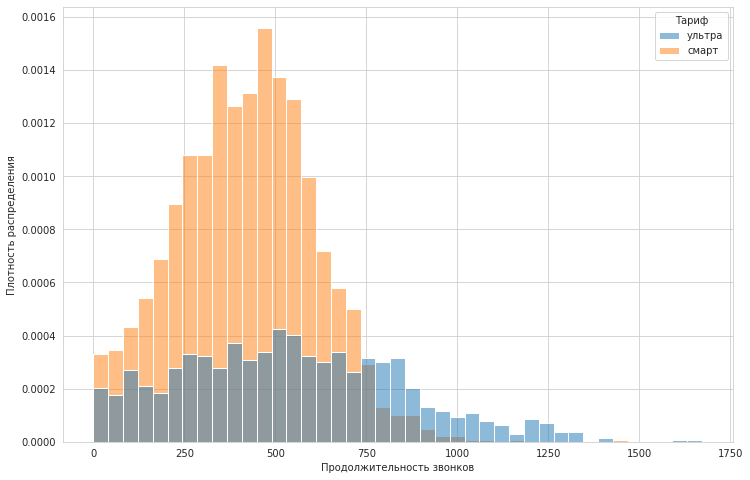

In [71]:
ax = sns.histplot(data=durations, x="calls_duration", hue="tariff", stat="density")
ax.set_xlabel("Продолжительность звонков")
ax.legend(ax.get_legend().legendHandles, ["ультра", "смарт"], title="Тариф")
ax.set_ylabel("Плотность распределения");

Видно, что клиенты с тарифом "Ультра" делают на 25% больше звонков, чем держатели тарифа "Смарт", как по количеству, так и по длительности. При этом дисперсия значений в обоих случаях в тарифе "Ультра" в 3 раза больше, чем в "Смарте". 

График распределения по времени разговоров за месяц аналогичем графику числа звонков.

По количеству сообщений:

In [72]:
messages = pd.wide_to_long(df_users, ["messages_"], i="user_id", j="month")[
    ["tariff", "messages_"]
].rename(columns={"messages_": "messages"})
messages.groupby("tariff").agg(["median", "mean", "std", "var", "max"])

messages                              
         median   mean    std      var    max
tariff                                       
smart      34.0  38.72  26.79   717.59  143.0
ultra      51.0  61.16  45.93  2109.66  224.0

Пользователи "Ультра" отправляют в 1,5 раза больше сообщений (по медианному значению), чем "Смарт". Соотношение дисперсий такое же как в звонках - 3:1.

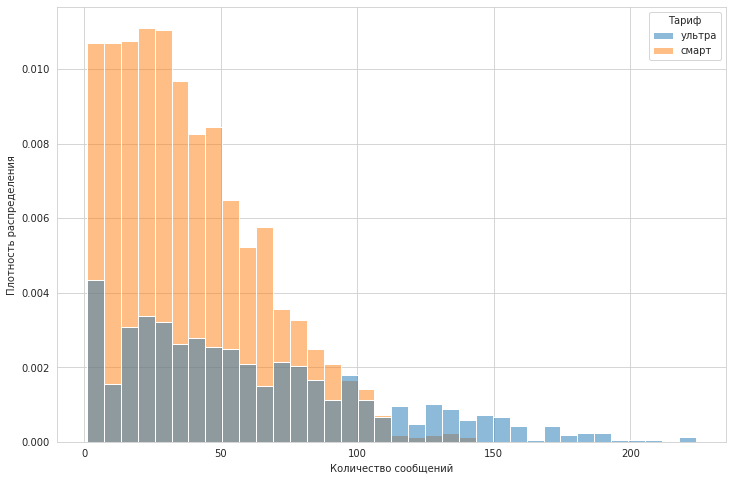

In [73]:
ax = sns.histplot(data=messages, x="messages", hue="tariff", stat="density")
ax.set_xlabel("Количество сообщений")
ax.legend(ax.get_legend().legendHandles, ["ультра", "смарт"], title="Тариф")
ax.set_ylabel("Плотность распределения");

Как и предыдущие графики, распределение количества сообщений напоминает распределение Пуассона (особенно хорошо это заметно для тарифа "Смарт").

Среди пользователей тарифа "Ультра" есть как большое количество практически не пользующихся SMS (выброс вблизи 0), так активные пользователи сообщений (вплоть до 224 в месяц).

И по использованию интернет-трафика:

In [74]:
internet = pd.wide_to_long(df_users, ["mb_used_"], i="user_id", j="month")[
    ["tariff", "mb_used_"]
].rename(columns={"mb_used_": "mb_used"})
internet.groupby("tariff").agg(["median", "mean", "std", "var", "max"])

mb_used                                      
         median      mean      std       var      max
tariff                                               
smart   17408.0  16735.76  5866.24  3.44e+07  38912.0
ultra   19456.0  20187.73  9919.83  9.84e+07  50176.0

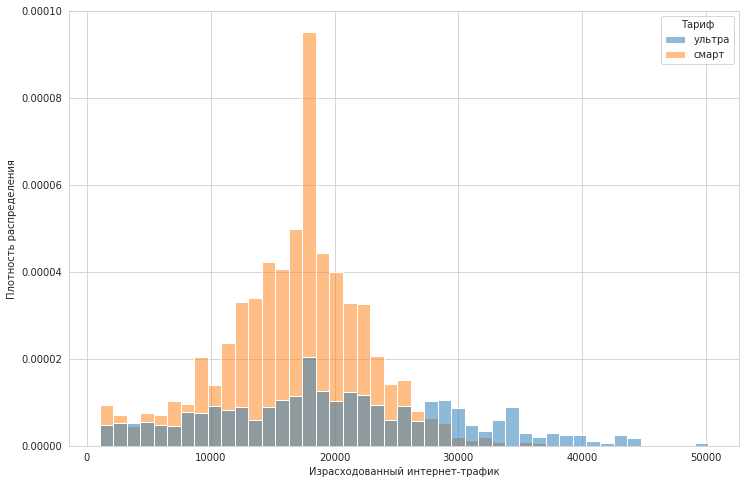

In [75]:
ax = sns.histplot(data=internet, x="mb_used", hue="tariff", stat="density")
ax.set_xlabel("Израсходованный интернет-трафик")
ax.legend(ax.get_legend().legendHandles, ["ультра", "смарт"], title="Тариф")
ax.set_ylabel("Плотность распределения");

По объёму использованного трафика пользователи тарифа "Ультра" также обгоняют "Смарт", но не так значительно, как в звонках или сообщениях: чуть больше, чем на 10% (по медиане). При этом соотношение дисперсий остаётся на удивление похожим: 3:1.

Видно, формы графиков использования интернета на обоих тарифах очень похожи и даже имеют пики в районе 18Гб. Но среди пользователей "Ультра" есть очень активные потребители мобильного интернета, вплоть до 50Гб в месяц.

Этот выброс говорит о том, что заметное количество пользователей тарифа "Смарт" перерасходуют трафик (предоплаченный лимит 15Гб), а много пользователей "Ультра" недоиспользуют доступный трацик (лимит 30Гб). Это указывает на то, что пользователи тарифа "Смарт" больше платят за интернет сверх абонентской платы.

Для удобства работы с платежами выделим их вместе с информацией о тарифе и городе в отдельный датафрейм

In [76]:
payments = pd.wide_to_long(df_users, ["payment_"], i="user_id", j="month")[
    ["tariff", "payment_", "city"]
].rename(columns={"payment_": "payment"})
payments.groupby("tariff").agg(["median", "mean", "std", "var", "max"])

payment                                    
        median     mean     std        var     max
tariff                                            
smart   1009.0  1282.09  817.57  668420.97  6770.0
ultra   1950.0  2067.64  372.63  138855.04  4800.0

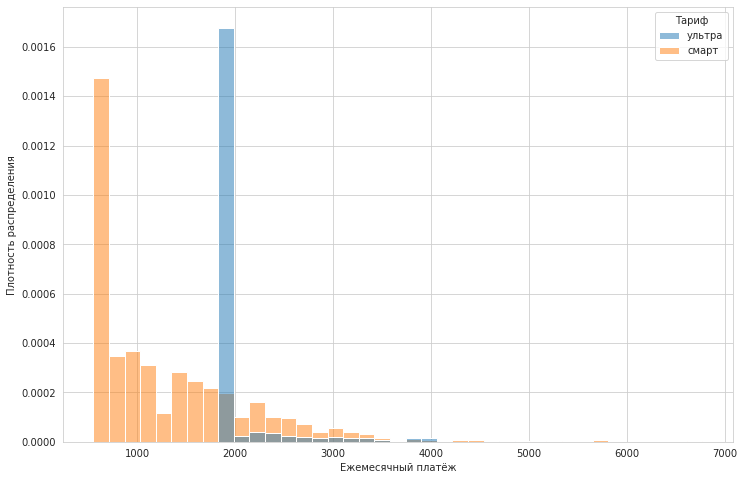

In [77]:
ax = sns.histplot(data=payments, x="payment", hue="tariff", stat="density")
ax.set_xlabel("Ежемесячный платёж")
ax.legend(ax.get_legend().legendHandles, ["ультра", "смарт"], title="Тариф")
ax.set_ylabel("Плотность распределения");

Что касается ежемесячных платежей, то видно, что основная часть пользователей остаются в рамках ежемнесячных платежей по выбранному тарифу. С другой стороны, есть и те, кто оплачивает использование услуг связи сверх тарифа и среди пользователей "смарт" таких явно больше (более толстый и длинный хвост). Более того, рекорд по ежемесячным платежам (6700 рублей за месяц) принадлежит именно пользователю с тарифом "Смарт".

### Выводы

В ходе исследования данных было установлено, что пользователи тарифа "Ультра" более активно используют услуги мобильной связи. Это не удивительно, иначе им бы не было смысла выбирать более дорогой тариф и большими лимитами.

Что же касается оплаты связи, то ситуация выглядит не вполне однозначной: с одной стороны, в массе своей пользователи "Ультра" платят бОльшую абонентскую плату, но среди пользователей "Смарт" есть пользователи со значительным перерасходом предоплаченных лимитов.

Исследуем платежи дополнительно.

## Анализ ежемесячных платежей

Мы уже увидели, что расходы на мобильную связь у пользователей с разными тарифными планами заметно отличаются, но насколько это различие существено? Проверим и это.

Прежде всего сформулируем статистическую гипотезу, которая в данном случае будет звучать как "предположим, что средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковы". Тогда альтернативная гипотеза будет утверждать, что средние платежи различаются. Гипотеза будет проверяться на двух независимых выборках (это непересекающиеся множества людей). Сравниваемые множества не одинаковы по длине и характер распределения платежей явно разный (это видно из графика выше), так что при проверке гипотезы мы будем использовать параметр `equal_var=False`.  

In [78]:
(
    payments.loc[payments["tariff"] == "smart", "payment"].dropna().shape[0],
    payments.loc[payments["tariff"] == "ultra", "payment"].dropna().shape[0],
)

(2253, 1006)

In [79]:
res = st.ttest_ind(
    payments.loc[payments["tariff"] == "smart", "payment"].dropna(),
    payments.loc[payments["tariff"] == "ultra", "payment"].dropna(),
    equal_var=False,
)

In [80]:
res.pvalue

3.6959751806665007e-258

Видно, что p-значение очень мало, настолько, что нет смысла выбирать между 1%, 5% или даже 0.1%. Средние заданных генеральных совокупностей отличают и очень значимо.

Теперь сравним платежи клиентов из разных городов: посмотрим отличается выручка москичей от средней выручки жителей других регионов. Нулевая гипотеза в данном случае звучит так: предположим, что ежемесячные платежи москвичей и клиентов из других регионов одинаковы. И альтернативная: предположим, что эти платежи отличаются.

В этом случае мы также имеем дело с непересекающимися группами людей. Группы эти существенно различаются по размеру, так что здесь также сть смысл исрользовать гипотезу о равенстве средних двух генеральных совокупностей в предположении неравенства их дисперсий:

In [81]:
(
    payments.loc[payments["city"] == "Москва"].shape[0],
    payments.loc[payments["city"] != "Москва"].shape[0],
)

(1188, 4812)

In [82]:
res = st.ttest_ind(
    payments.loc[payments["city"] == "Москва", "payment"].dropna(),
    payments.loc[payments["city"] != "Москва", "payment"].dropna(),
    equal_var=False,
)

In [83]:
res

Ttest_indResult(statistic=0.8034270065320763, pvalue=0.42192271461069386)

### Выводы

Мы сравнили ежемесячные платежи пользователей оператора. Было установлено, что с очень высокой значимостью платежи пользователей тарифов "Смарт" и "Ультра" отличаются.

С другой стороны, сравнение ежемесячных расходов москвичей и жителей других регионов не дало овозможностей отвергнуть гипотезу о равенстве расходов на мобильную связь этих двух групп.

## Выводы

В ходе анализа активности выборки пользователей двух тарифов оператора связи было установлено следующее:
- пользователи тарифа "Ультра" активнее пользуются услугами связи: на 26% больше по звонкам, на 56% по сообщениям и на 20% по интернет-трафику (всё &mdash; по медианным значениям);
- пользователи тарифа "Смарт" чаще и значительнее выходят за лимиты тарифа и как следствие платят сверх абонентской платы: медианные месячные переплаты для тарифа "Смарт" составляют 732 рубля против 118 для тарифа "Ультра".

Если исходить из того, что абонентская плата назначена правильно (в соответствии с затаратами оператора на обслуживание клиентов), то тариф "Смарт" более выгоден оператору, поскольку генерирует больший дополнительный денежный поток.